---------------------------------------------------------------------------------------------------

In [1]:
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram, circuit_drawer

from collections import Counter
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import AutoMinorLocator, NullLocator
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, entropy

from qiskit_experiments.library.tomography import StateTomography

In [2]:
%matplotlib inline

---------------------------------------------------------------------------------------------------

## $\textbf{Algoritmo de Deutsch - Jozsa}$

---------------------------------------------------------------------------------------------------

### $\textbf{Caso n=2 (qbits entrada)}$

Caso $n = 2$ qbits de entrada

Las dos constantes y estas dos 

* $f(01) = f(10) = f(00) = f(11) = 1$
* $f(01) = f(10) = f(00) = f(11) = 0$
* $f(01) = f(10) = 0$, $f(00) = f(11) = 1$
* $f(00) = f(01) = 0$, $f(11) = f(10) = 1$

In [3]:
#ORACULOS n=2

#CONSTANTES
def oracle_cte_1_DJn2(quantumCircuit):
    quantumCircuit.x(2)  #solo cambio el valor al qbit objetivo
    return quantumCircuit

def oracle_cte_0_DJn2(quantumCircuit): #no hace mucho, pero quiero dejarla para que signifique algo
    quantumCircuit.id(0) 
    return quantumCircuit

#BALANCEADAS

def oracle_bal_1_DJn2(quantumCircuit):
    quantumCircuit.cx(0, 2)
    return quantumCircuit

def oracle_bal_2_DJn2(quantumCircuit):
    quantumCircuit.cx(1, 2)
    return quantumCircuit

def oracle_bal_3_DJn2(quantumCircuit):
    quantumCircuit.cx(0, 2)
    quantumCircuit.cx(1, 2)
    return quantumCircuit

#bal4
def oracle_bal_4_DJn2(quantumCircuit):
    quantumCircuit.x(2)
    quantumCircuit.cx(0, 2)
    quantumCircuit.cx(1, 2)
    return quantumCircuit

def oracle_bal_5_DJn2(quantumCircuit):
    quantumCircuit.x(2)
    quantumCircuit.cx(1, 2)
    return quantumCircuit

def oracle_bal_6_DJn2(quantumCircuit):
    quantumCircuit.x(2)
    quantumCircuit.cx(0, 2)
    return quantumCircuit

In [4]:
def DeutschJozsa_n2(oracle):
    """Crea un circuito cuantico con 3 qbits y un bit clasico, establece el estado en |0⟩^{2}|1⟩, aplica una compuerta Hadamard a cada uno, se pasa el estado por un oráculo, despúes se aplica una compurta Hadamard al qbit control y se mide. 

    Args:
        oracle (_func_): _description_f
    """
    
    quantumCircuit = QuantumCircuit(3, 2)
    
    quantumCircuit.id(0)
    quantumCircuit.id(1)
    quantumCircuit.x(2)
    
    quantumCircuit.h(0)
    quantumCircuit.h(1)
    quantumCircuit.h(2)
    
    quantumCircuit.barrier()
    
    oracle(quantumCircuit)
    
    quantumCircuit.barrier()
    
    quantumCircuit.h(0)
    quantumCircuit.h(1)
    
    quantumCircuit.measure(0, 0)
    quantumCircuit.measure(1, 1)
    
    return quantumCircuit

In [ ]:
oraculos = [oracle_cte_1_DJn2, oracle_cte_0_DJn2, oracle_bal_1_DJn2, oracle_bal_2_DJn2]
nombres_oraculos = [r'Circuito para la función constante $f(0)=0, \; f(1) = 0$',
           r'Circuito para la función constante $f(0)=1, \; f(1) = 1$',
           r'Circuito para la función balanceada $f(0)=0, \; f(1) = 1$',
           r'Circuito para la función balanceada $f(0)=1, \; f(1) = 0$']

nombres_imagenes = ['cte1', 'cte2', 'bal1', 'bal2' ]

for oracle_func, nombre, n1 in zip(oraculos, nombres_oraculos, nombres_imagenes):

    q_cDJ_2 = DeutschJozsa_n2(oracle_func)

    fig, ax = plt.subplots(figsize=(8, 4))
    
    q_cDJ_2.draw('mpl', ax=ax)

    fig.suptitle(nombre, fontsize=16, y=0.98)  

    fig.subplots_adjust(top=0.85, bottom=0.2)  

    plt.show()

    fig.savefig(n1+'.png', dpi=300, bbox_inches='tight')

In [5]:
c_0_DJ_n2 = DeutschJozsa_n2(oracle_cte_0_DJn2)
c_1_DJ_n2 = DeutschJozsa_n2(oracle_cte_1_DJn2)

c_bal1_DJ_n2 = DeutschJozsa_n2(oracle_bal_1_DJn2)
c_bal2_DJ_n2 = DeutschJozsa_n2(oracle_bal_2_DJn2)
c_bal3_DJ_n2 = DeutschJozsa_n2(oracle_bal_3_DJn2)
c_bal4_DJ_n2 = DeutschJozsa_n2(oracle_bal_4_DJn2)
c_bal5_DJ_n2 = DeutschJozsa_n2(oracle_bal_5_DJn2)
c_bal6_DJ_n2 = DeutschJozsa_n2(oracle_bal_6_DJn2)

---------------------------------------------------------------------------------------------------

#### $\textbf{Simulaciones}$

In [151]:

sampler = StatevectorSampler()

job = sampler.run([c_bal1_DJ_n2,
                   c_bal2_DJ_n2,
                   c_bal3_DJ_n2,
                   c_bal4_DJ_n2,
                   c_bal5_DJ_n2,
                   c_bal6_DJ_n2], shots=4096)

sim_result = job.result()

sim_counts_list_DJ_n2 = []
estados_deseados = ['0', '1', '2', '3']  

for pub_result in sim_result:
    bits = [''.join(str(bit) for bit in b) for b in pub_result.data.c.array]
    counts = Counter(bits)

    for estado in estados_deseados:
        if estado not in counts:
            counts[estado] = 0

    sim_counts_list_DJ_n2.append(counts)

In [152]:
sim_counts_list_DJ_n2

[Counter({'1': 4096, '0': 0, '2': 0, '3': 0}),
 Counter({'2': 4096, '0': 0, '1': 0, '3': 0}),
 Counter({'3': 4096, '0': 0, '1': 0, '2': 0}),
 Counter({'3': 4096, '0': 0, '1': 0, '2': 0}),
 Counter({'2': 4096, '0': 0, '1': 0, '3': 0}),
 Counter({'1': 4096, '0': 0, '2': 0, '3': 0})]

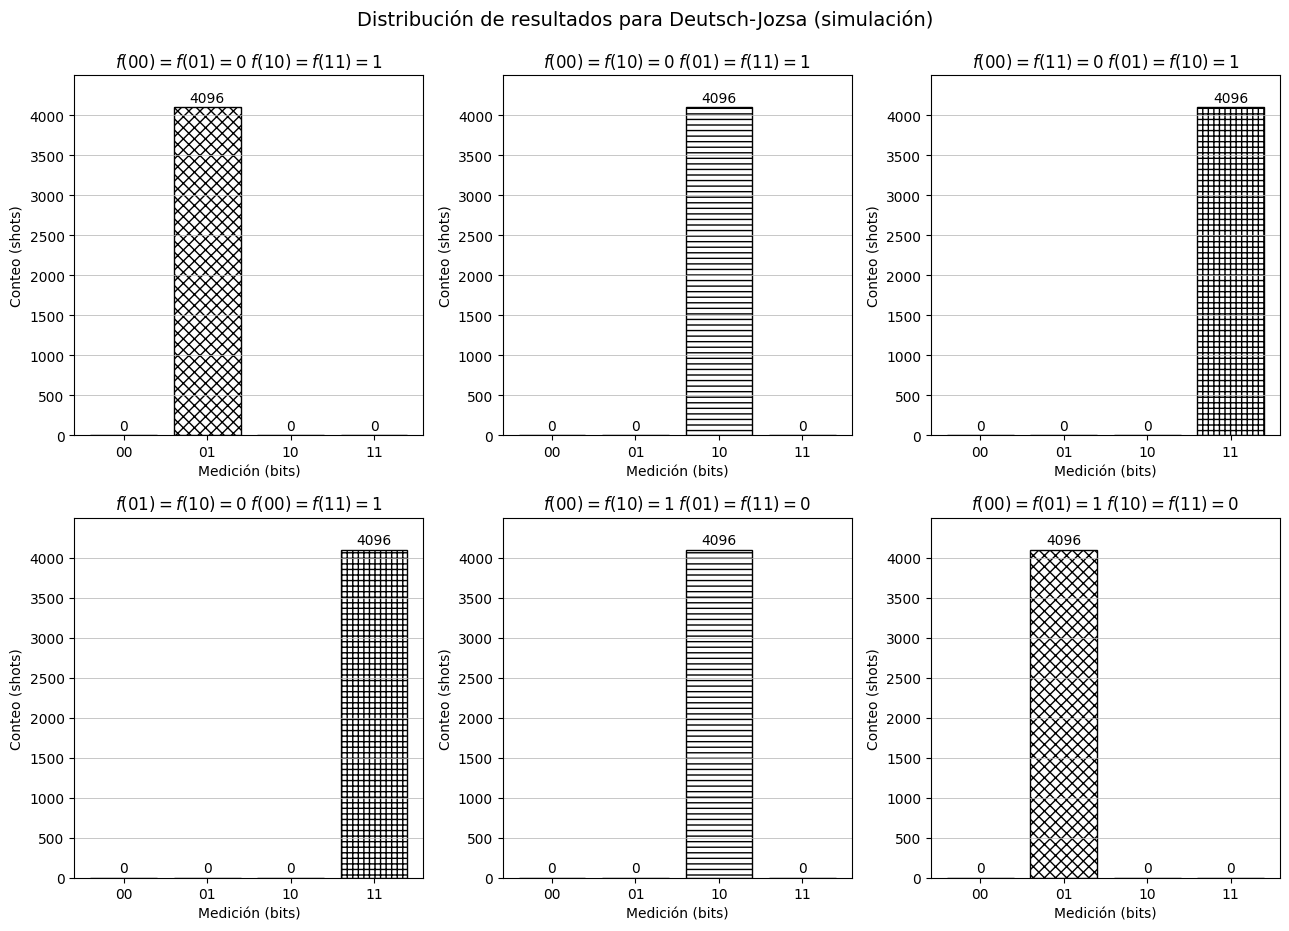

In [97]:

labels = [r'$f(00)=f(01)= 0 \; f(10)=f(11)=1$', 
          r'$f(00)=f(10)= 0 \; f(01)=f(11)=1$',
          r'$f(00)=f(11)= 0 \; f(01)=f(10)=1$',
          r'$f(01)=f(10)= 0 \; f(00)=f(11)=1$',
          r'$f(00)=f(10)= 1 \; f(01)=f(11)=0$',
          r'$f(00)=f(01)= 1 \; f(10)=f(11)=0$',]

hatch_map = {
    '00': '///',
    '01': 'xxx',
    '10': '---',
    '11': '+++'
}

fig, axs = plt.subplots(2, 3, figsize=(13, 9))
axs = axs.flatten()

for i in range(6):
    counts = sim_counts_list_DJ_n2[i]
    ax = axs[i]
    
    keys_decimal = sorted(counts.keys(), key=int)   
    keys = [format(int(k), '02b') for k in keys_decimal]  
    values = [counts[k] for k in keys_decimal]

    bars = []
    for j, k in enumerate(keys):
        hatch = hatch_map.get(k, '...')
        bar = ax.bar(k, values[j], color='white', edgecolor='black', hatch=hatch)
        bars.append(bar)

    #ax.set_yscale('log')
    ax.set_title(labels[i])
    ax.set_ylim(0, max(values)+ 400)
    ax.set_ylabel('Conteo (shots)')
    ax.set_xlabel('Medición (bits)')
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)

    for j, bar in enumerate(bars):
        height = values[j]
        ax.text(
            keys[j], height + 30, str(height),
            ha='center', va='bottom', fontsize=10
        )

plt.tight_layout()
plt.suptitle('Distribución de resultados para Deutsch-Jozsa (simulación)', fontsize=14, y=1.03)
plt.savefig('deutsch_simn2bal.png', dpi=300, bbox_inches='tight')
plt.show()


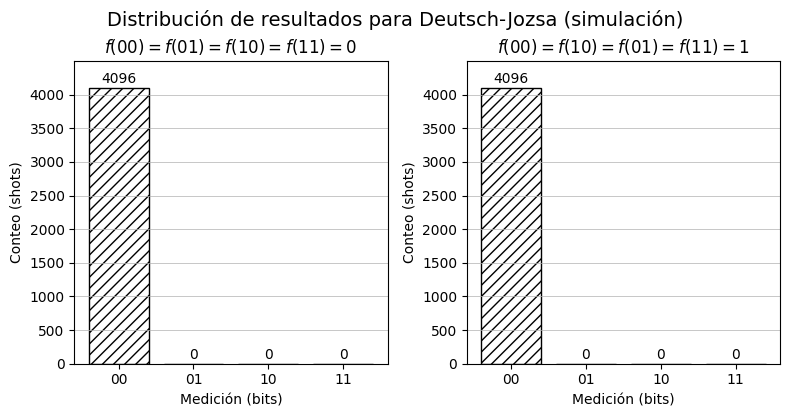

In [101]:

labels = [r'$f(00)=f(01)=f(10)=f(11)=0$', 
          r'$f(00)=f(10)=f(01)=f(11)=1$']

hatch_map = {
    '00': '///',
    '01': 'xxx',
    '10': '---',
    '11': '+++'
}

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs = axs.flatten()

for i in range(2):
    counts = sim_counts_list_DJ_n2[i]
    ax = axs[i]

    
    keys_decimal = sorted(counts.keys(), key=int)   
    keys = [format(int(k), '02b') for k in keys_decimal]  
    values = [counts[k] for k in keys_decimal]

    bars = []
    for j, k in enumerate(keys):
        hatch = hatch_map.get(k, '...')
        bar = ax.bar(k, values[j], color='white', edgecolor='black', hatch=hatch)
        bars.append(bar)

    ax.set_title(labels[i])
    ax.set_ylim(0, max(values) + 400)
    ax.set_ylabel('Conteo (shots)')
    ax.set_xlabel('Medición (bits)')
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)

    for j, bar in enumerate(bars):
        height = values[j]
        ax.text(
            keys[j], height + 30, str(height),
            ha='center', va='bottom', fontsize=10
        )

plt.tight_layout()
plt.suptitle('Distribución de resultados para Deutsch-Jozsa (simulación)', fontsize=14, y=1.03)
plt.savefig('deutsch_simn2cte.png', dpi=300, bbox_inches='tight')
plt.show()


---------------------------------------------------------------------------------------------------

#### $\textbf{Criterio de pureza}$

In [109]:
def entrelazamiento_DeutschJozsan2(circuito):
    
    circuito_sinMedicion = circuito.remove_final_measurements(inplace=False)

    estadoCuantico = Statevector.from_instruction(circuito_sinMedicion)

    matriz_densidad = DensityMatrix(estadoCuantico)
    
    rho = matriz_densidad.data
    traza_matriz_densidad = np.trace(rho @ rho).real    
    
    if traza_matriz_densidad > 0.9:
        
        matriz_densidad_reducida = partial_trace(matriz_densidad, [1]).data

        pureza = (matriz_densidad_reducida @ matriz_densidad_reducida).trace().real
    
        return pureza
        
    else:
        print('No se puede afirmar nada sobre el entrelazamiento en el estado.')

In [110]:
c_0 = 'Función constante  f(00) = f(01) = f(10) = f(11) = 0 | Pureza: ' + str(entrelazamiento_DeutschJozsan2(c_0_DJ_n2))
c_1 = 'Función constante  f(00) = f(01) = f(10) = f(11) = 1 | Pureza: ' + str(entrelazamiento_DeutschJozsan2(c_1_DJ_n2))


b_1 = 'Función balanceada f(00) = f(01) = 0, f(10) = f(11) = 1 | Pureza: ' + str(entrelazamiento_DeutschJozsan2(c_bal1_DJ_n2))
b_2 = 'Función balanceada f(00) = f(11) = 0, f(01) = f(11) = 1 | Pureza: ' + str(entrelazamiento_DeutschJozsan2(c_bal2_DJ_n2))
b_3 = 'Función balanceada f(00) = f(11) = 0, f(01) = f(10) = 1 | Pureza: ' + str(entrelazamiento_DeutschJozsan2(c_bal3_DJ_n2))
b_4 = 'Función balanceada f(01) = f(10) = 0, f(00) = f(11) = 0 | Pureza: ' + str(entrelazamiento_DeutschJozsan2(c_bal4_DJ_n2))
b_5 = 'Función balanceada f(00) = f(10) = 1, f(01) = f(11) = 0 | Pureza: ' + str(entrelazamiento_DeutschJozsan2(c_bal5_DJ_n2))
b_6 = 'Función balanceada f(00) = f(01) = 1, f(10) = f(11) = 0 | Pureza: ' + str(entrelazamiento_DeutschJozsan2(c_bal6_DJ_n2))

print(c_0)
print(c_1)
print(b_1)
print(b_2)
print(b_3)
print(b_4)
print(b_5)
print(b_6)


Función constante  f(00) = f(01) = f(10) = f(11) = 0 | Pureza: 0.9999999999999984
Función constante  f(00) = f(01) = f(10) = f(11) = 1 | Pureza: 0.9999999999999984
Función balanceada f(00) = f(01) = 0, f(10) = f(11) = 1 | Pureza: 0.9999999999999984
Función balanceada f(00) = f(11) = 0, f(01) = f(11) = 1 | Pureza: 0.9999999999999984
Función balanceada f(00) = f(11) = 0, f(01) = f(10) = 1 | Pureza: 0.9999999999999984
Función balanceada f(01) = f(10) = 0, f(00) = f(11) = 0 | Pureza: 0.9999999999999984
Función balanceada f(00) = f(10) = 1, f(01) = f(11) = 0 | Pureza: 0.9999999999999984
Función balanceada f(00) = f(01) = 1, f(10) = f(11) = 0 | Pureza: 0.9999999999999984


---------------------------------------------------------------------------------------------------

#### $\textbf{Device IBM}$

In [12]:
def guardar_resultados_deutsch(result, nombre_archivo):
    
    all_counts = []
    all_bitstrings = set()

    for i, pub_result in enumerate(result):
        bits = [''.join(str(bit) for bit in b) for b in pub_result.data.c.array]
        counts = Counter(bits)
        all_counts.append((f"circuito_{i+1}", counts))
        all_bitstrings.update(counts.keys())

    bit_columns = sorted(all_bitstrings)

    with open(nombre_archivo, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["nombre_circuito"] + bit_columns)
        for nombre, counts in all_counts:
            row = [nombre] + [counts.get(b, 0) for b in bit_columns]
            writer.writerow(row)

In [19]:
QiskitRuntimeService.save_account(token='4b8a1c91375bada9d51da5fa78db963cf7a0adb8339e5928eb279da7fdf9c8bcb179dff9a77fe25ac2ad833ba3ee84b468bdd7246efe96830667c2b425b0d153', channel='ibm_quantum', overwrite=True)

service = QiskitRuntimeService()

backend = service.least_busy(operational=True, simulator=False)

c_0_DJ_n2 = DeutschJozsa_n2(oracle_cte_0_DJn2)
c_1_DJ_n2 = DeutschJozsa_n2(oracle_cte_1_DJn2)

c_bal1_DJ_n2 = DeutschJozsa_n2(oracle_bal_1_DJn2)
c_bal2_DJ_n2 = DeutschJozsa_n2(oracle_bal_2_DJn2)
c_bal3_DJ_n2 = DeutschJozsa_n2(oracle_bal_3_DJn2)
c_bal4_DJ_n2 = DeutschJozsa_n2(oracle_bal_4_DJn2)
c_bal5_DJ_n2 = DeutschJozsa_n2(oracle_bal_5_DJn2)
c_bal6_DJ_n2 = DeutschJozsa_n2(oracle_bal_6_DJn2)

circuitos_transpilados_DJ_n2 = transpile([c_0_DJ_n2,
                                          c_1_DJ_n2,
                                          c_bal1_DJ_n2, 
                                          c_bal2_DJ_n2,
                                          c_bal3_DJ_n2,
                                          c_bal4_DJ_n2,
                                          c_bal5_DJ_n2,
                                          c_bal6_DJ_n2], backend=backend)

sampler = Sampler(mode=backend)
job = sampler.run(circuitos_transpilados_DJ_n2, shots=4096)
result = job.result()


guardar_resultados_deutsch(result, "resultado_deutschJozsa_n2_p2.csv")

In [146]:
import pandas as pd
df = pd.read_csv("resultado_deutschJozsa_n2_p2.csv")

estados = df.columns[1:]

real_counts_list = []
for _, fila in df.iterrows():
    counts = Counter({estado: int(fila[estado]) for estado in estados})
    real_counts_list.append(counts)

nombres = df["nombre_circuito"].tolist()

In [147]:
real_counts_list

[Counter({'0': 4042, '2': 35, '1': 19, '3': 0}),
 Counter({'0': 4043, '2': 39, '1': 14, '3': 0}),
 Counter({'1': 4040, '0': 42, '3': 14, '2': 0}),
 Counter({'2': 4029, '0': 44, '3': 23, '1': 0}),
 Counter({'3': 3932, '1': 89, '2': 64, '0': 11}),
 Counter({'3': 3953, '1': 77, '2': 50, '0': 16}),
 Counter({'2': 4003, '0': 51, '3': 41, '1': 1}),
 Counter({'1': 4033, '0': 47, '3': 16, '2': 0})]

In [153]:
sim_counts_list_DJ_n2

[Counter({'1': 4096, '0': 0, '2': 0, '3': 0}),
 Counter({'2': 4096, '0': 0, '1': 0, '3': 0}),
 Counter({'3': 4096, '0': 0, '1': 0, '2': 0}),
 Counter({'3': 4096, '0': 0, '1': 0, '2': 0}),
 Counter({'2': 4096, '0': 0, '1': 0, '3': 0}),
 Counter({'1': 4096, '0': 0, '2': 0, '3': 0})]

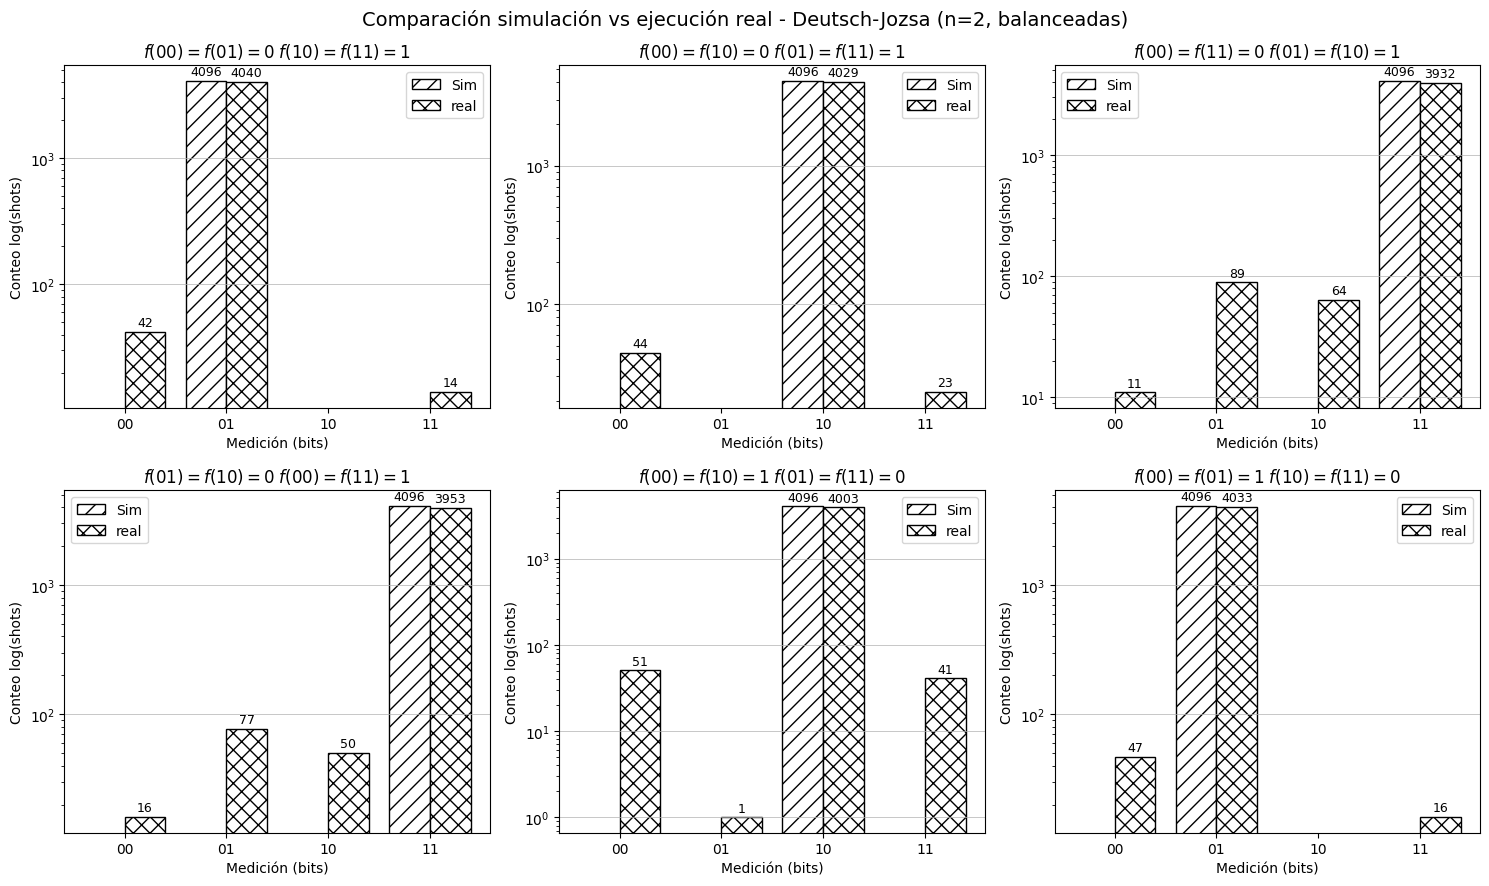

In [171]:
import matplotlib.pyplot as plt
import numpy as np

labels = [r'$f(00)=f(01)= 0 \; f(10)=f(11)=1$', 
          r'$f(00)=f(10)= 0 \; f(01)=f(11)=1$',
          r'$f(00)=f(11)= 0 \; f(01)=f(10)=1$',
          r'$f(01)=f(10)= 0 \; f(00)=f(11)=1$',
          r'$f(00)=f(10)= 1 \; f(01)=f(11)=0$',
          r'$f(00)=f(01)= 1 \; f(10)=f(11)=0$',]

sim = sim_counts_list_DJ_n2           
real = real_counts_list[2:]           

min_len = min(len(sim), len(real))    

fig, axs = plt.subplots(2, 3, figsize=(15, 9))
axs = axs.flatten()

for i in range(min_len):
    sim_counts = sim[i]
    real_counts = real[i]
    
    keys = sorted(set(sim_counts) | set(real_counts), key=int)
    x = np.arange(len(keys))
    xticks = [format(int(k), '02b') for k in keys]

    sim_vals = [sim_counts.get(k, 0) for k in keys]
    real_vals = [real_counts.get(k, 0) for k in keys]

    ax = axs[i]
    bars_sim = ax.bar(x - 0.2, sim_vals, width=0.4, label='Sim', hatch='//', edgecolor='black', color='white')
    bars_real = ax.bar(x + 0.2, real_vals, width=0.4, label='real', hatch='xx', edgecolor='black', color='white')

    
    for bar in bars_sim:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height * 1.05,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

    for bar in bars_real:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height * 1.05,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)
    ax.set_yscale('log')
    ax.set_xticks(x)
    ax.set_xticklabels(xticks)
    ax.set_title(labels[i])
    ax.set_xlabel("Medición (bits)")
    ax.set_ylabel("Conteo log(shots)")
    ax.legend()

plt.suptitle("Comparación simulación vs ejecución real - Deutsch-Jozsa (n=2, balanceadas)", fontsize=14)
plt.tight_layout()
plt.savefig('djcomparacionn2.png', dpi=300, bbox_inches='tight')
plt.show()


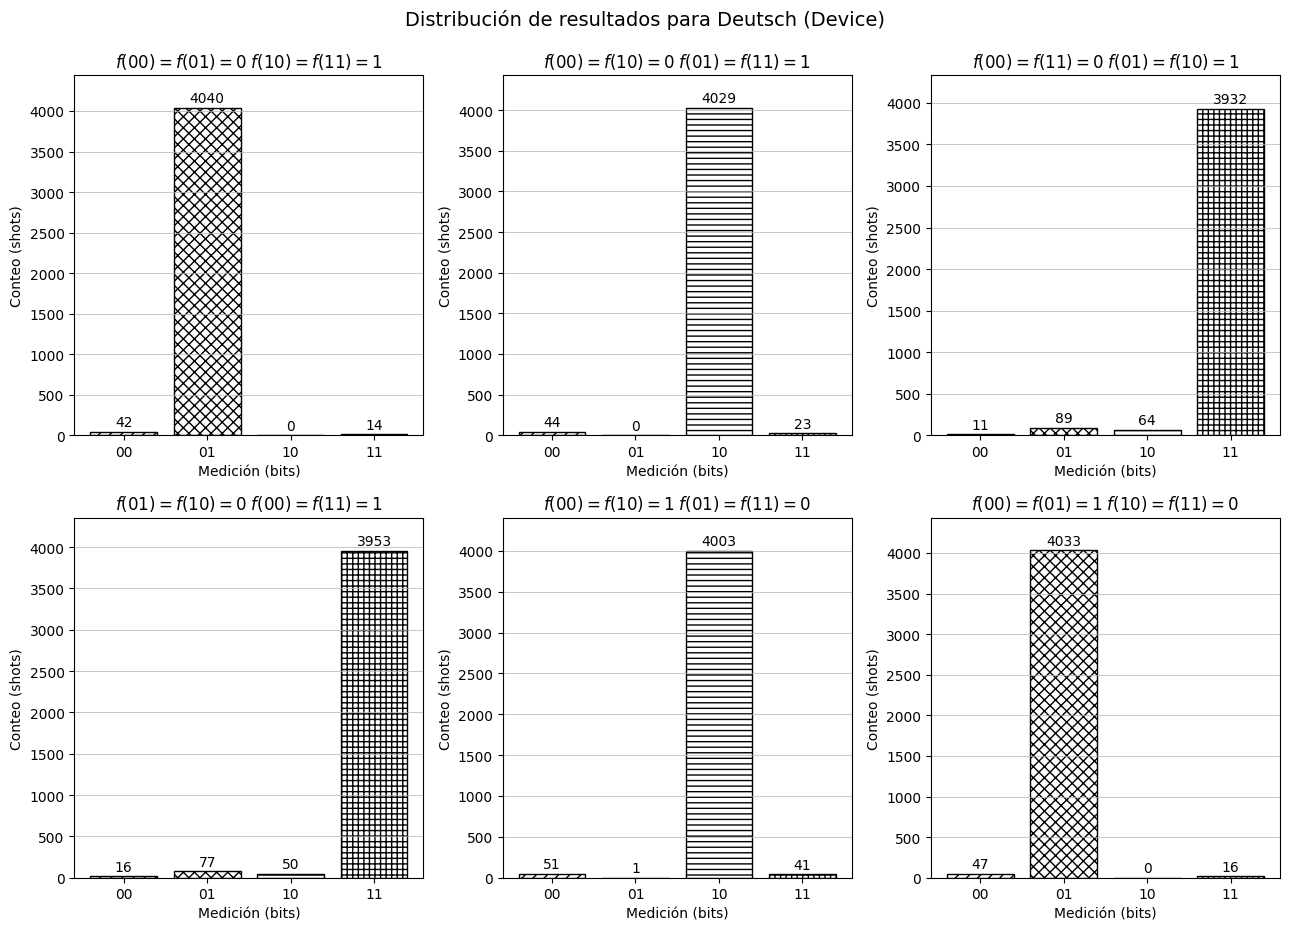

In [106]:
labels = [r'$f(00)=f(01)= 0 \; f(10)=f(11)=1$', 
          r'$f(00)=f(10)= 0 \; f(01)=f(11)=1$',
          r'$f(00)=f(11)= 0 \; f(01)=f(10)=1$',
          r'$f(01)=f(10)= 0 \; f(00)=f(11)=1$',
          r'$f(00)=f(10)= 1 \; f(01)=f(11)=0$',
          r'$f(00)=f(01)= 1 \; f(10)=f(11)=0$',]

hatch_map = {
    '00': '///',
    '01': 'xxx',
    '10': '---',
    '11': '+++'
}

fig, axs = plt.subplots(2, 3, figsize=(13, 9))
axs = axs.flatten()

n = 0
for i in range(2, 8):
    counts = real_counts_list[i]
    ax = axs[n]

    keys_decimal = sorted(counts.keys(), key=int)   
    keys = [format(int(k), '02b') for k in keys_decimal]  
    values = [counts[k] for k in keys_decimal]

    bars = []
    for j, k in enumerate(keys):
        bar = ax.bar(k, values[j], color='white', edgecolor='black', hatch=hatch_map[k])
        bars.append(bar)

    #ax.set_yscale('log')
    ax.set_title(labels[n])
    ax.set_ylim(0, max(values)+400)
    ax.set_ylabel('Conteo (shots)')
    ax.set_xlabel('Medición (bits)')
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)

    for j, bar in enumerate(bars):
        height = values[j]
        ax.text(
            keys[j], height + 30, str(height),
            ha='center', va='bottom', fontsize=10
        )
        
    n += 1

plt.tight_layout()
plt.suptitle('Distribución de resultados para Deutsch (Device)', fontsize=14, y=1.03)
plt.savefig('deutsch_devicen2_bal.png', dpi=300, bbox_inches='tight')
plt.show()


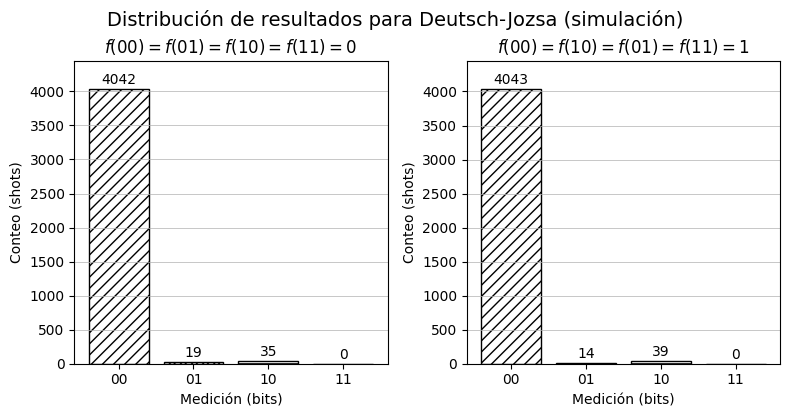

In [108]:

labels = [r'$f(00)=f(01)=f(10)=f(11)=0$', 
          r'$f(00)=f(10)=f(01)=f(11)=1$']

hatch_map = {
    '00': '///',
    '01': 'xxx',
    '10': '---',
    '11': '+++'
}

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs = axs.flatten()

for i in range(2):
    counts = real_counts_list[i]
    ax = axs[i]

    
    keys_decimal = sorted(counts.keys(), key=int)   
    keys = [format(int(k), '02b') for k in keys_decimal]  
    values = [counts[k] for k in keys_decimal]

    bars = []
    for j, k in enumerate(keys):
        hatch = hatch_map.get(k, '...')
        bar = ax.bar(k, values[j], color='white', edgecolor='black', hatch=hatch)
        bars.append(bar)

    ax.set_title(labels[i])
    ax.set_ylim(0, max(values) + 400)
    ax.set_ylabel('Conteo (shots)')
    ax.set_xlabel('Medición (bits)')
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)

    for j, bar in enumerate(bars):
        height = values[j]
        ax.text(
            keys[j], height + 30, str(height),
            ha='center', va='bottom', fontsize=10
        )

plt.tight_layout()
plt.suptitle('Distribución de resultados para Deutsch-Jozsa (simulación)', fontsize=14, y=1.03)
plt.savefig('deutsch_device2cte.png', dpi=300, bbox_inches='tight')
plt.show()


---------------------------------------------------------------------------------------------------

### $\textbf{Caso n=3 (qbits entrada)}$

* $f(x) = x1x2 \oplus x3$
* $f(x) = x1 \oplus x2 \oplus x3$

In [3]:
def orc(quantumCircuit):
    quantumCircuit.ccx(0,1,3)
    quantumCircuit.ccx(1,2,3)
    quantumCircuit.cx(2,3)
    return quantumCircuit

def orc1(quantumCircuit):
    quantumCircuit.ccx(0,1,3)
    quantumCircuit.cx(2,3)
    return quantumCircuit

def orc2(quantumCircuit):
    quantumCircuit.cx(0, 3)
    quantumCircuit.cx(1, 3)
    quantumCircuit.cx(2, 3)
    return quantumCircuit

def orc3(quantumCircuit):
    quantumCircuit.ccx(0, 2, 3)  
    quantumCircuit.ccx(1, 2, 3)  
    quantumCircuit.cx(0, 3) 
    return quantumCircuit

In [4]:
def DeutschJozsa_n3(oracle):
    """Crea un circuito cuantico con 3 qbits y un bit clasico, establece el estado en |0⟩^{2}|1⟩, aplica una compuerta Hadamard a cada uno, se pasa el estado por un oráculo, despúes se aplica una compurta Hadamard al qbit control y se mide. 

    Args:
        oracle (_func_): _description_f
    """
    
    quantumCircuit = QuantumCircuit(4, 3) 
    
    quantumCircuit.id(0)
    quantumCircuit.id(1)
    quantumCircuit.id(2)
    quantumCircuit.x(3)
    
    quantumCircuit.h(0)
    quantumCircuit.h(1)
    quantumCircuit.h(2)
    quantumCircuit.h(3)
    
    quantumCircuit.barrier()
    
    oracle(quantumCircuit)
    
    quantumCircuit.barrier()
    
    quantumCircuit.h(0)
    quantumCircuit.h(1)
    quantumCircuit.h(2)
    
    quantumCircuit.measure(0, 0)
    quantumCircuit.measure(1, 1)
    quantumCircuit.measure(2, 2)
    
    return quantumCircuit

---------------------------------------------------------------------------------------------------

### $\textbf{Simulaciones}$

In [5]:
circ = DeutschJozsa_n3(orc)
circ1 = DeutschJozsa_n3(orc1)
circ2 = DeutschJozsa_n3(orc2)
circ3 = DeutschJozsa_n3(orc3)

In [6]:

sampler = StatevectorSampler()

job = sampler.run([circ,
                   circ1,
                   circ2,
                   circ3], shots=4096)

sim_result = job.result()

sim_counts_list_DJ_n3 = []
estados_deseados = ['0', '1', '2', '3', '4', '5', '6', '7']  

for pub_result in sim_result:
    bits = [''.join(str(bit) for bit in b) for b in pub_result.data.c.array]
    counts = Counter(bits)

    for estado in estados_deseados:
        if estado not in counts:
            counts[estado] = 0

    sim_counts_list_DJ_n3.append(counts)

In [130]:
sim_counts_list_DJ_n3

[Counter({'6': 1066,
          '3': 1029,
          '4': 1021,
          '1': 980,
          '0': 0,
          '2': 0,
          '5': 0,
          '7': 0}),
 Counter({'5': 1031,
          '6': 1029,
          '7': 1025,
          '4': 1011,
          '0': 0,
          '1': 0,
          '2': 0,
          '3': 0}),
 Counter({'0': 1052,
          '2': 1017,
          '3': 1015,
          '1': 1012,
          '4': 0,
          '5': 0,
          '6': 0,
          '7': 0}),
 Counter({'6': 1108,
          '5': 1011,
          '1': 1008,
          '2': 969,
          '0': 0,
          '3': 0,
          '4': 0,
          '7': 0})]

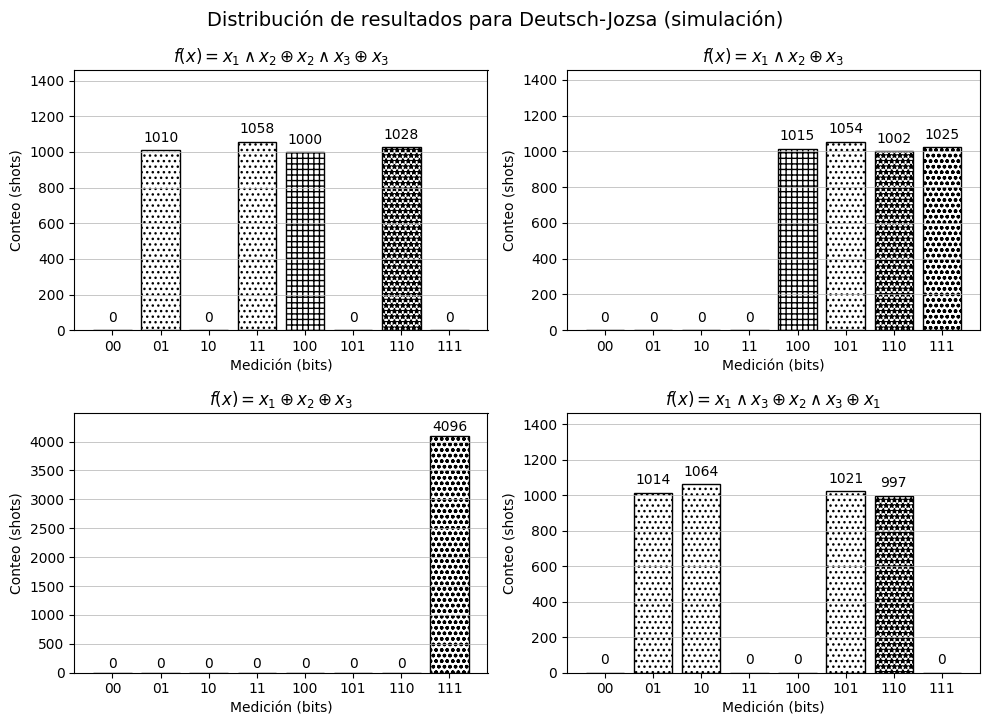

In [7]:

labels = [r'$f(x)=x_1 \wedge x_2\oplus x_2 \wedge x_3 \oplus x_3 $', 
          r'$f(x)=x_1 \wedge x_2 \oplus x_3$',
          r'$f(x) = x_1 \oplus x_2 \oplus x_3$',
          r'$f(x)= x_1 \wedge x_3\oplus x_2 \wedge x_3 \oplus x_1$']

hatch_map = {
    '000': '///',
    '001': 'xxx',
    '010': '---',
    '100': '+++',
    '110': '\\\\\\',  
    '101': '...',     
    '110': '***',      
    '111': 'ooo' 
}

fig, axs = plt.subplots(2, 2, figsize=(10, 7))
axs = axs.flatten()

for i in range(4):
    counts = sim_counts_list_DJ_n3[i]
    ax = axs[i]
    
    keys_decimal = sorted(counts.keys(), key=int)   
    keys = [format(int(k), '02b') for k in keys_decimal]  
    values = [counts[k] for k in keys_decimal]

    bars = []
    for j, k in enumerate(keys):
        hatch = hatch_map.get(k, '...')
        bar = ax.bar(k, values[j], color='white', edgecolor='black', hatch=hatch)
        bars.append(bar)

    #ax.set_yscale('log')
    ax.set_title(labels[i])
    ax.set_ylim(0, max(values)+ 400)
    ax.set_ylabel('Conteo (shots)')
    ax.set_xlabel('Medición (bits)')
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)

    for j, bar in enumerate(bars):
        height = values[j]
        ax.text(
            keys[j], height + 30, str(height),
            ha='center', va='bottom', fontsize=10
        )

plt.tight_layout()
plt.suptitle('Distribución de resultados para Deutsch-Jozsa (simulación)', fontsize=14, y=1.03)
plt.savefig('deutsch_simn3bal.png', dpi=300, bbox_inches='tight')
plt.show()


---------------------------------------------------------------------------------------------------

### $\textbf{Criterio de pureza sim}$

In [ ]:
from scipy.linalg import logm

def entropia_von_Neumann(rho):
    log_rho = logm(rho)
    return -np.real(np.trace(rho @ log_rho))

In [8]:
def entrelazamiento_DeutschJozsan3(circuito):
    
    circuito_sinMedicion = circuito.remove_final_measurements(inplace=False)

    estadoCuantico = Statevector.from_instruction(circuito_sinMedicion)

    matriz_densidad = DensityMatrix(estadoCuantico)
    
    rho = matriz_densidad.data

    traza_matriz_densidad = np.trace(rho @ rho).real    
    
    if traza_matriz_densidad > 0.9:
        
        matriz_densidad_reducida = partial_trace(matriz_densidad, [2]).data

        pureza = (matriz_densidad_reducida @ matriz_densidad_reducida).trace().real
    
        return pureza
        
    else:
        print('No se puede afirmar nada sobre el entrelazamiento en el estado.')

In [9]:
djn3b1 = DeutschJozsa_n3(orc)
djn3b2 = DeutschJozsa_n3(orc1)
djn3b3 = DeutschJozsa_n3(orc2)
djn3b4 = DeutschJozsa_n3(orc3)

b_1 = 'Función balanceada a | Pureza: ' + str(entrelazamiento_DeutschJozsan3(djn3b1))
b_2 = 'Función balanceada b | Pureza: ' + str(entrelazamiento_DeutschJozsan3(djn3b2))
b_3 = 'Función balanceada c | Pureza: ' + str(entrelazamiento_DeutschJozsan3(djn3b3))
b_4 = 'Función balanceada d | Pureza: ' + str(entrelazamiento_DeutschJozsan3(djn3b4))


print(b_1)
print(b_2)
print(b_3)
print(b_4)

Función balanceada a | Pureza: 0.4999999999999989
Función balanceada b | Pureza: 0.9999999999999978
Función balanceada c | Pureza: 0.9999999999999978
Función balanceada d | Pureza: 0.4999999999999989


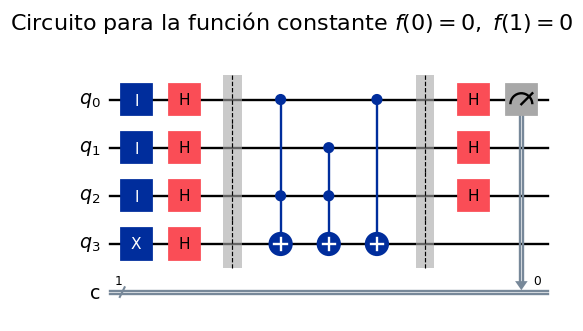

In [35]:
q_cDJ_2 = DeutschJozsa_n3(orc3)

fig, ax = plt.subplots(figsize=(8, 4))

q_cDJ_2.draw('mpl', ax=ax)

fig.suptitle(nombre, fontsize=16, y=0.98)  

fig.subplots_adjust(top=0.85, bottom=0.2)  

plt.show()

fig.savefig('n3.png', dpi=300, bbox_inches='tight')

In [10]:
def deutsch_jozsa_entrelazado(n=100):
    qc = QuantumCircuit(n + 1)
    
    qc.x(n)
    
    qc.h(range(n + 1))
    
    qc.ccx(0, 1, n)
    qc.ccx(2, 3, n)
    qc.cx(4, n)
    
    qc.h(range(n))
    
    return qc


def entrelazamiento_DJ(circuito):
    from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
    
    circuito_sin_med = circuito.remove_final_measurements(inplace=False)
    
    estado = Statevector.from_instruction(circuito_sin_med)
    rho = DensityMatrix(estado)
    
   
    rho_reducida = partial_trace(rho, [circuito.num_qubits - 11])
    
   
    pureza = np.trace(rho_reducida.data @ rho_reducida.data).real
    
    return pureza

qc = deutsch_jozsa_entrelazado(10)
pureza = entrelazamiento_DJ(qc)
print("Pureza del sistema de entrada:", pureza)


Pureza del sistema de entrada: 0.49999999999999667


---------------------------------------------------------------------------------------------------

#### $\textbf{Device IBM}$

In [13]:
QiskitRuntimeService.save_account(token='4b8a1c91375bada9d51da5fa78db963cf7a0adb8339e5928eb279da7fdf9c8bcb179dff9a77fe25ac2ad833ba3ee84b468bdd7246efe96830667c2b425b0d153', channel='ibm_quantum', overwrite=True)

service = QiskitRuntimeService()

backend = service.least_busy(operational=True, simulator=False)

djn3b1 = DeutschJozsa_n3(orc)
djn3b2 = DeutschJozsa_n3(orc1)
djn3b3 = DeutschJozsa_n3(orc2)
djn3b4 = DeutschJozsa_n3(orc3)

circuitos_transpilados_DJ_n2 = transpile([djn3b1,
                                          djn3b2,
                                          djn3b3,
                                          djn3b4], backend=backend)

sampler = Sampler(mode=backend)
job = sampler.run(circuitos_transpilados_DJ_n2, shots=4096)
result = job.result()


guardar_resultados_deutsch(result, "resultado_deutschJozsa_n3.csv")

In [14]:
import pandas as pd
df = pd.read_csv("resultado_deutschJozsa_n3.csv")

estados = df.columns[1:]

real_counts_list_n3 = []
for _, fila in df.iterrows():
    counts = Counter({estado: int(fila[estado]) for estado in estados})
    real_counts_list_n3.append(counts)

nombres = df["nombre_circuito"].tolist()

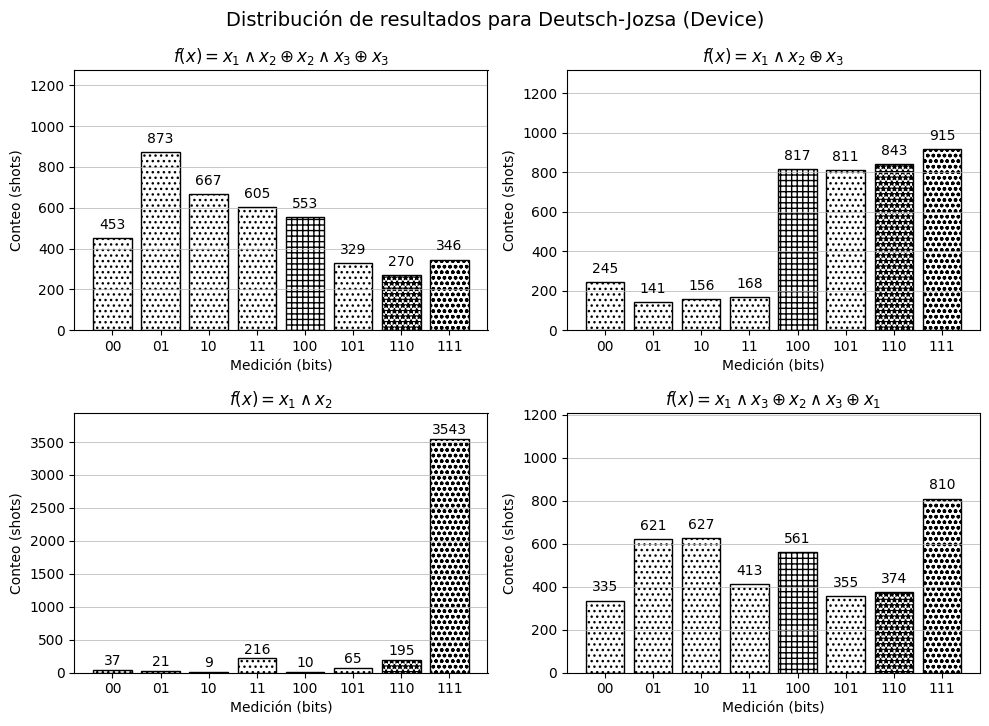

In [16]:

labels = [r'$f(x)=x_1 \wedge x_2\oplus x_2 \wedge x_3 \oplus x_3 $', 
          r'$f(x)=x_1 \wedge x_2 \oplus x_3$',
          r'$f(x) = x_1 \wedge x_2$',
          r'$f(x)= x_1 \wedge x_3\oplus x_2 \wedge x_3 \oplus x_1$']

hatch_map = {
    '000': '///',
    '001': 'xxx',
    '010': '---',
    '100': '+++',
    '110': '\\\\\\',  
    '101': '...',     
    '110': '***',      
    '111': 'ooo' 
}

fig, axs = plt.subplots(2, 2, figsize=(10, 7))
axs = axs.flatten()

for i in range(4):
    counts = real_counts_list_n3[i]
    ax = axs[i]
    
    keys_decimal = sorted(counts.keys(), key=int)   
    keys = [format(int(k), '02b') for k in keys_decimal]  
    values = [counts[k] for k in keys_decimal]

    bars = []
    for j, k in enumerate(keys):
        hatch = hatch_map.get(k, '...')
        bar = ax.bar(k, values[j], color='white', edgecolor='black', hatch=hatch)
        bars.append(bar)

    #ax.set_yscale('log')
    ax.set_title(labels[i])
    ax.set_ylim(0, max(values)+ 400)
    ax.set_ylabel('Conteo (shots)')
    ax.set_xlabel('Medición (bits)')
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)

    for j, bar in enumerate(bars):
        height = values[j]
        ax.text(
            keys[j], height + 30, str(height),
            ha='center', va='bottom', fontsize=10
        )

plt.tight_layout()
plt.suptitle('Distribución de resultados para Deutsch-Jozsa (Device)', fontsize=14, y=1.03)
plt.savefig('deutsch_devicen3bal.png', dpi=300, bbox_inches='tight')
plt.show()

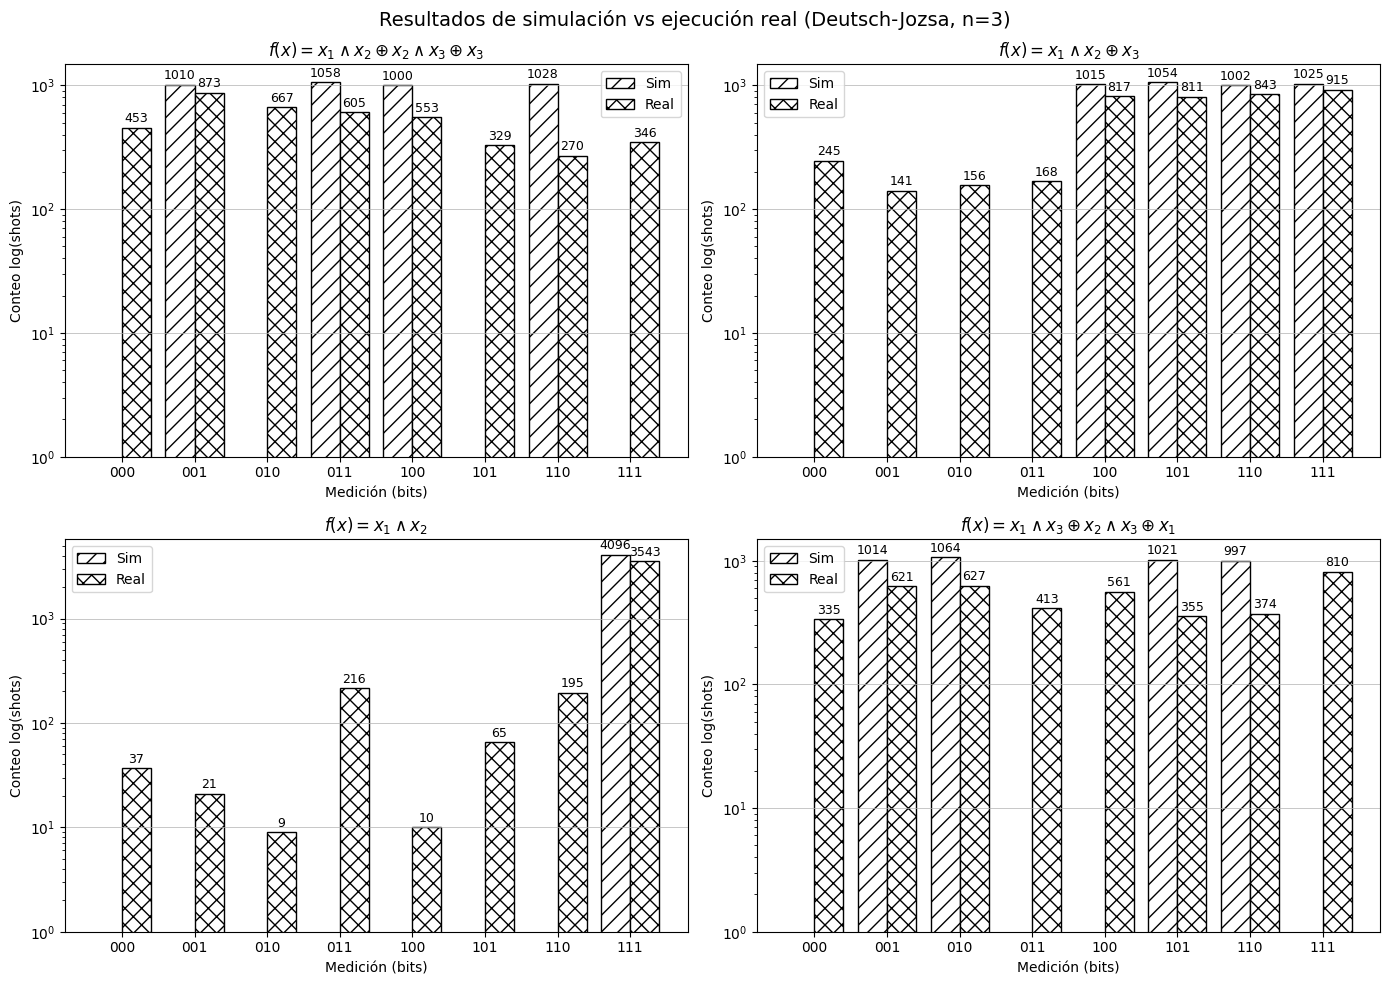

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter



labels = [
    r'$f(x) = x_1 \wedge x_2 \oplus x_2 \wedge x_3 \oplus x_3$',
    r'$f(x) = x_1 \wedge x_2 \oplus x_3$',
    r'$f(x) = x_1 \wedge x_2$',
    r'$f(x) = x_1 \wedge x_3 \oplus x_2 \wedge x_3 \oplus x_1$'
]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i in range(4):
    sim, real = sim_counts_list_DJ_n3[i], real_counts_list_n3[i]
    keys = sorted(set(sim) | set(real), key=int)
    x = np.arange(len(keys))
    xticks = [format(int(k), '03b') for k in keys]

    sim_vals = [sim.get(k, 0) for k in keys]
    real_vals = [real.get(k, 0) for k in keys]

    ax = axs[i]
    bars_sim = ax.bar(x - 0.2, sim_vals, width=0.4, label='Sim', hatch='//', edgecolor='black', color='white')
    bars_real = ax.bar(x + 0.2, real_vals, width=0.4, label='Real', hatch='xx', edgecolor='black', color='white')


    max_height = max(sim_vals + real_vals)
    ax.set_ylim(1, max_height * 1.4)

 
    for bar in bars_sim:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height * 1.05,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

    for bar in bars_real:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height * 1.05,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)
    ax.set_yscale('log')
    ax.set_xticks(x)
    ax.set_xticklabels(xticks)
    ax.set_title(labels[i])
    ax.set_xlabel("Medición (bits)")
    ax.set_ylabel("Conteo log(shots)")
    ax.legend()

plt.suptitle("Resultados de simulación vs ejecución real (Deutsch-Jozsa, n=3)", fontsize=14)
plt.tight_layout()
plt.savefig('deutschn3_log.png', dpi=300, bbox_inches='tight')
plt.show()
